# CPSC 330 - Applied Machine Learning 

## Homework 6: Putting it all together 
### Associated lectures: All material till lecture 13 

**Due date: Monday, November 15, 2021 at 11:59pm**

## Table of contents

- [Submission instructions](#si)
- [Understanding the problem](#1)
- [Data splitting](#2)
- [EDA](#3)
- (Optional) [Feature engineering](#4)
- [Preprocessing and transformations](#5)
- [Baseline model](#6)
- [Linear models](#7)
- [Different classifiers](#8)
- (Optional) [Feature selection](#9)
- [Hyperparameter optimization](#10)
- [Interpretation and feature importances](#11)
- [Results on the test set](#12)
- (Optional) [Explaining predictions](#13)
- [Summary of the results](#14)

## Imports 

In [2]:
import os

%matplotlib inline
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb
from scipy.stats import loguniform, randint
from lightgbm.sklearn import LGBMClassifier
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    f1_score,
    make_scorer,
    plot_confusion_matrix,
)
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC

<br><br>

## Instructions 
<hr>
rubric={points:2}

Follow the [homework submission instructions](https://github.com/UBC-CS/cpsc330/blob/master/docs/homework_instructions.md). 

**You may work on this homework in a group and submit your assignment as a group.** Below are some instructions on working as a group.  
- The maximum group size is 3. 
- Use group work as an opportunity to collaborate and learn new things from each other. 
- Be respectful to each other and make sure you understand all the concepts in the assignment well. 
- It's your responsibility to make sure that the assignment is submitted by one of the group members before the deadline. 
- You can find the instructions on how to do group submission on Gradescope [here](https://help.gradescope.com/article/m5qz2xsnjy-student-add-group-members).

<br><br>

## Introduction <a name="in"></a>
<hr>

At this point we are at the end of supervised machine learning part of the course. So in this homework, you will be working on an open-ended mini-project, where you will put all the different things you have learned so far together to solve an interesting problem.

A few notes and tips when you work on this mini-project: 

#### Tips

1. This mini-project is open-ended, and while working on it, there might be some situations where you'll have to use your own judgment and make your own decisions (as you would be doing when you work as a data scientist). Make sure you explain your decisions whenever necessary. 
2. **Do not include everything you ever tried in your submission** -- it's fine just to have your final code. That said, your code should be reproducible and well-documented. For example, if you chose your hyperparameters based on some hyperparameter optimization experiment, you should leave in the code for that experiment so that someone else could re-run it and obtain the same hyperparameters, rather than mysteriously just setting the hyperparameters to some (carefully chosen) values in your code. 
3. If you realize that you are repeating a lot of code try to organize it in functions. Clear presentation of your code, experiments, and results is the key to be successful in this lab. You may use code from lecture notes or previous lab solutions with appropriate attributions. 
4. If you are having trouble running models on your laptop because of the size of the dataset, you can create your train/test split in such a way that you have less data in the train split. If you end up doing this, please write a note to the grader in the submission explaining why you are doing it.  

#### Assessment

We plan to grade fairly and leniently. We don't have some secret target score that you need to achieve to get a good grade. **You'll be assessed on demonstration of mastery of course topics, clear presentation, and the quality of your analysis and results.** For example, if you just have a bunch of code and no text or figures, that's not good. If you do a bunch of sane things and get a lower accuracy than your friend, don't sweat it.

#### A final note

Finally, this style of this "project" question is different from other assignments. It'll be up to you to decide when you're "done" -- in fact, this is one of the hardest parts of real projects. But please don't spend WAY too much time on this... perhaps "a few hours" (2-8 hours???) is a good guideline for a typical submission. Of course if you're having fun you're welcome to spend as much time as you want! But, if so, try not to do it out of perfectionism or getting the best possible grade. Do it because you're learning and enjoying it. Students from the past cohorts have found such kind of labs useful and fun and I hope you enjoy it as well. 

<br><br>

## 1. Understanding the problem <a name="1"></a>
<hr>
rubric={points:4}

In this mini project, you will be working on a classification problem of predicting whether a credit card client will default or not. 
For this problem, you will use [Default of Credit Card Clients Dataset](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). In this data set, there are 30,000 examples and 24 features, and the goal is to estimate whether a person will default (fail to pay) their credit card bills; this column is labeled "default.payment.next.month" in the data. The rest of the columns can be used as features. You may take some ideas and compare your results with [the associated research paper](https://www.sciencedirect.com/science/article/pii/S0957417407006719), which is available through [the UBC library](https://www.library.ubc.ca/). 

**Your tasks:**

1. Spend some time understanding the problem and what each feature means. You can find this information in the documentation on [the dataset page on Kaggle](https://www.kaggle.com/uciml/default-of-credit-card-clients-dataset). Write a few sentences on your initial thoughts on the problem and the dataset. 
2. Download the dataset and read it as a pandas dataframe. 

We are predicting whether people are going to default on a credit card bill payment

**Features**
* `ID` is the index
* `default.payment.next.month` is the target
    * Default payment (1=yes, 0=no) 

**Categorical**
* `MARRIAGE`: Marital status 
    * (1=married, 2=single, 3=others)
* `EDUCATION`: (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown) We should be consolidating 5 and 6. 
* `PAY_X`: Repayment status 
    * (-2: No consumption; -1: Paid in full; 0: The use of revolving credit; 1 = payment delay for one month; 2 = payment delay for two months; . . .; 9 = payment delay for nine months and above.)
    * PAY_0: in September, 2005
        * We should rename this to PAY_1 to be consistent with the BILL_AMT and PAY_AMT
    * PAY_2: in August, 2005
    * PAY_3: in July, 2005
    * PAY_4: in June, 2005
    * PAY_5: in May, 2005
    * PAY_6: in April, 2005

**Binary**
* `SEX`: Gender (1=male, 2=female)
    * we should leave this out, it is inappropriate to use sex to determine whether someone will default on their credit card payment.

**Numerical**
* `AGE`: Age in years
* `LIMIT_BAL`: Amount of given credit in NT dollars (includes individual and family/supplementary credit)
* `BILL_AMTX`: Amount of bill statement in NT dollar
    * BILL_AMT1: in September, 2005
    * BILL_AMT2: in August, 2005
    * BILL_AMT3: in July, 2005
    * BILL_AMT4: in June, 2005
    * BILL_AMT5: in May, 2005
    * BILL_AMT6: in April, 2005
* `PAY_AMTX`: Amount of previous payment
    * PAY_AMT1: in September, 2005
    * PAY_AMT2: in August, 2005
    * PAY_AMT3: in July, 2005
    * PAY_AMT4: in June, 2005
    * PAY_AMT5: in May, 2005
    * PAY_AMT6: in April, 2005



In [3]:
df = pd.read_csv("UCI_Credit_Card.csv")
df = df.set_index('ID')
df = df.rename(columns={"PAY_0": "PAY_1"})
df = df.rename(columns={"default.payment.next.month": "DEFAULT"})
df.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT
ID,,,,,,,,,,,,,,,,,,,,,
1,20000.0,2,2,1,24,2,2,-1,-1,-2,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
2,120000.0,2,2,2,26,-1,2,0,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
3,90000.0,2,2,2,34,0,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
4,50000.0,2,2,1,37,0,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
5,50000.0,1,2,1,57,-1,0,-1,0,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## 2. Data splitting <a name="2"></a>
<hr>
rubric={points:2}

**Your tasks:**

1. Split the data into train and test portions. 

In [4]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
X_train = train_df.drop(columns=['DEFAULT'])
X_test  = test_df.drop(columns=['DEFAULT'])
y_train = train_df['DEFAULT']
y_test = test_df['DEFAULT']

## 3. EDA <a name="3"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Perform exploratory data analysis on the train set.
2. Include at least two summary statistics and two visualizations that you find useful, and accompany each one with a sentence explaining it.
3. Summarize your initial observations about the data. 
4. Pick appropriate metric/metrics for assessment. 

In [6]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24000 entries, 19683 to 19967
Data columns (total 23 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   LIMIT_BAL  24000 non-null  float64
 1   SEX        24000 non-null  int64  
 2   EDUCATION  24000 non-null  int64  
 3   MARRIAGE   24000 non-null  int64  
 4   AGE        24000 non-null  int64  
 5   PAY_1      24000 non-null  int64  
 6   PAY_2      24000 non-null  int64  
 7   PAY_3      24000 non-null  int64  
 8   PAY_4      24000 non-null  int64  
 9   PAY_5      24000 non-null  int64  
 10  PAY_6      24000 non-null  int64  
 11  BILL_AMT1  24000 non-null  float64
 12  BILL_AMT2  24000 non-null  float64
 13  BILL_AMT3  24000 non-null  float64
 14  BILL_AMT4  24000 non-null  float64
 15  BILL_AMT5  24000 non-null  float64
 16  BILL_AMT6  24000 non-null  float64
 17  PAY_AMT1   24000 non-null  float64
 18  PAY_AMT2   24000 non-null  float64
 19  PAY_AMT3   24000 non-null  float64
 20  PA

In [7]:
X_train.describe()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
count,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,...,24000.000000,24000.000000,24000.000000,24000.000000,24000.000000,2.400000e+04,24000.000000,24000.000000,24000.000000,24000.000000
mean,167893.486667,1.603125,1.851958,1.553375,35.488458,-0.017542,-0.135292,-0.170042,-0.224292,-0.265583,...,46955.185083,43389.105625,40297.970375,38708.777542,5656.319917,5.910454e+03,5280.658708,4763.854250,4805.837667,5277.577958
std,130109.666875,0.489260,0.790560,0.521452,9.217424,1.125331,1.199812,1.201709,1.170630,1.136707,...,68841.868958,64572.844994,60878.153831,59355.284889,16757.718059,2.134743e+04,17973.951980,15162.056345,15251.828322,18222.046645
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,...,-157264.000000,-65167.000000,-61372.000000,-339603.000000,0.000000,0.000000e+00,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,...,2663.000000,2310.000000,1744.250000,1200.000000,990.000000,8.150000e+02,390.000000,281.750000,234.000000,110.750000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,20038.000000,19032.000000,18019.000000,16812.500000,2100.000000,2.010000e+03,1801.500000,1500.000000,1500.000000,1500.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,59970.250000,54591.500000,50237.250000,49132.750000,5009.000000,5.000000e+03,4600.000000,4026.000000,4009.250000,4000.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,...,855086.000000,891586.000000,927171.000000,961664.000000,873552.000000,1.227082e+06,896040.000000,621000.000000,426529.000000,528666.000000


In [8]:
X_train.MARRIAGE.value_counts()

2    12798
1    10905
3      260
0       37
Name: MARRIAGE, dtype: int64

This summary statistic shows us the counts of values in the `MARRIAGE` feature. There are some with value 0, which we do not have in our legend (1=married, 2=single, 3=others). We should change all the 0s to 3s as they can safely be categorized as 'others'.

In [7]:
X_train.EDUCATION.value_counts()

2    14030
1    10585
3     4917
5      280
4      123
6       51
0       14
Name: EDUCATION, dtype: int64

This summary statistic shows us the counts of values in the `EDUCATION` feature. There are some with value 0, which we do not have in our legend (1=graduate school, 2=university, 3=high school, 4=others, 5=unknown, 6=unknown). We should change all the 0s to 5s as they can safely be categorized as 'unknown', we can also change al the 6s to 5s since they are both for the same category ('unknown').

In [9]:
X_train.PAY_1.value_counts()

 0    11783
-1     4604
 1     2939
-2     2183
 2     2110
 3      265
 4       60
 5       22
 8       16
 6        9
 7        9
Name: PAY_1, dtype: int64

<AxesSubplot:>

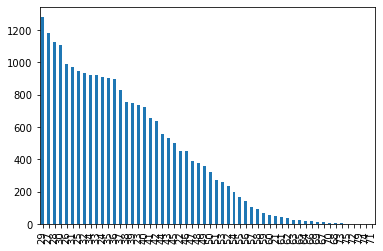

In [10]:
X_train.AGE.value_counts().plot(kind = 'bar')

Gives us an idea of the age distribution of our dataset. Theres some imbalance but this is okay.

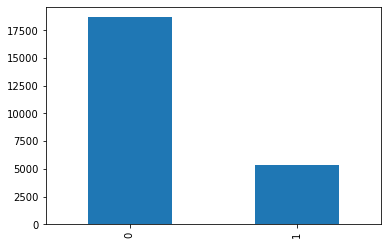

In [12]:
temp = y_train.value_counts().plot(kind = 'bar')

Gives us an idea of the target value distribution in the dataset. We clearly have a large class imbalance.

4. Appropriate metric for assessment is  validation/test accuracy since we are doing supervised machine learning. 

An appropriate metric would be recall since we have class imbalance and are trying to identify 'positive' examples. But we will use f1-score since it is more appropriate for hyper parameter optimization.

In [62]:
scoring = "f1"

## (Optional) 4. Feature engineering <a name="4"></a>
<hr>
rubric={points:1}

**Your tasks:**

1. Carry out feature engineering. In other words, extract new features relevant for the problem and work with your new feature set in the following exercises. You may have to go back and forth between feature engineering and preprocessing. 

## 5. Preprocessing and transformations <a name="5"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Identify different feature types and the transformations you would apply on each feature type. 
2. Define a column transformer, if necessary. 

In [63]:
drop_features = ['SEX']
numeric_features = [
    'AGE',
    'LIMIT_BAL',
    'BILL_AMT1',
    'BILL_AMT2',
    'BILL_AMT3',
    'BILL_AMT4',
    'BILL_AMT5',
    'BILL_AMT6',
    'PAY_AMT1',
    'PAY_AMT2',
    'PAY_AMT3',
    'PAY_AMT4',
    'PAY_AMT5',
    'PAY_AMT6',

]
categorical_features = [
    'MARRIAGE', 
    'EDUCATION',
    'PAY_1',
    'PAY_2',
    'PAY_3',
    'PAY_4',
    'PAY_5',
    'PAY_6',
    ]

In [64]:
df.MARRIAGE = df.MARRIAGE.replace([0], 3)
df.EDUCATION = df.EDUCATION.replace([0, 6], 5)

In [65]:
# drop features will be dropped since they are not included
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),  # scaling on numeric features so they effect models evenly
    (OneHotEncoder(sparse=False, handle_unknown = 'ignore'), categorical_features),  # OHE on categorical features so that we can use them in models
)

## 6. Baseline model <a name="6"></a>
<hr>

rubric={points:2}

**Your tasks:**
1. Try `scikit-learn`'s baseline model and report results.

In [66]:
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train); # fit the classifier
print("The accuracy of the model on the training data: %0.3f" % (dummy_clf.score(X_train, y_train)))

The accuracy of the model on the training data: 0.778


## 7. Linear models <a name="7"></a>
<hr>
rubric={points:12}

**Your tasks:**

1. Try logistic regression as a first real attempt. 
2. Carry out hyperparameter tuning to explore different values for the complexity hyperparameter `C`. 
3. Report validation scores along with standard deviation. 
4. Summarize your results.

In [67]:
log_reg = LogisticRegression(max_iter=1000)
pipe = make_pipeline(preprocessor, log_reg)

In [ ]:
param_grid = {
    "logisticregression__C": [0.1, 1.0, 10, 100, 1000],
}

grid_search = GridSearchCV(pipe, param_grid, cv=5, n_jobs=-1, return_train_score=True, scoring=scoring)
grid_search.fit(X_train, y_train)
results = pd.DataFrame(grid_search.cv_results_)

In [69]:
results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_logisticregression__C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.453560,0.197746,0.036240,0.004449,0.1,{'logisticregression__C': 0.1},0.461820,0.461059,0.444305,0.494204,...,0.465197,0.016166,4,0.469514,0.473538,0.473725,0.459913,0.470878,0.469514,0.005059
1,10.372561,1.788064,0.056135,0.012184,1.0,{'logisticregression__C': 1.0},0.459658,0.459527,0.447220,0.496652,...,0.464881,0.016672,5,0.472300,0.473684,0.475985,0.463112,0.473019,0.471620,0.004430
2,16.432112,3.810027,0.040808,0.002916,10,{'logisticregression__C': 10},0.458996,0.461443,0.445836,0.499392,...,0.465710,0.017893,1,0.472902,0.474754,0.476454,0.463543,0.473676,0.472266,0.004521
3,25.705909,2.022958,0.029850,0.005274,100,{'logisticregression__C': 100},0.458996,0.461156,0.445141,0.499696,...,0.465574,0.018176,2,0.473285,0.474754,0.476528,0.463377,0.473749,0.472338,0.004617
4,21.755532,2.538203,0.015967,0.005806,1000,{'logisticregression__C': 1000},0.458996,0.461156,0.445141,0.499696,...,0.465574,0.018176,2,0.473595,0.474754,0.476528,0.463615,0.473514,0.472401,0.004526


The results are not great, we are correctly identifying a little more than a 3rd of the positive examples. The differences between the test scores and train scores are practically the same. We opt to use a C value of 10 as it gives us the best test score and does not appear to be overfitting the model.

## 8. Different classifiers <a name="8"></a>
<hr>
rubric={points:15}

**Your tasks:**
1. Try at least 3 other models aside from logistic regression. At least one of these models should be a tree-based ensemble model (e.g., lgbm, random forest, xgboost). 
2. Summarize your results. Can you beat logistic regression? 

In [70]:
models = {
    "SVM RBF": SVC(max_iter=1000),
    "Random Forest": RandomForestClassifier(),
    "LGBM": LGBMClassifier(),
}

In [71]:
out = {}

for name in models:
    pipeline = make_pipeline(preprocessor, models[name])
    out[name] = cross_validate(pipeline, X_train, y_train, scoring=scoring, return_train_score=True)

In [72]:
pd.DataFrame(out['SVM RBF'])

,fit_time,score_time,test_score,train_score
0,2.284749,0.592014,0.179367,0.205950
1,2.237137,0.589354,0.368517,0.375178
2,2.901468,0.607427,0.093294,0.090253
3,2.528211,0.585471,0.250856,0.250081
4,2.740446,0.599626,0.407631,0.408421


In [73]:
pd.DataFrame(out['Random Forest'])

,fit_time,score_time,test_score,train_score
0,3.092749,0.094869,0.454002,0.997303
1,3.090821,0.097519,0.464180,0.997536
2,3.181124,0.090986,0.463592,0.998359
3,3.052958,0.090372,0.504728,0.997536
4,3.109062,0.096986,0.463488,0.997889


In [74]:
pd.DataFrame(out['LGBM'])

,fit_time,score_time,test_score,train_score
0,0.243408,0.013421,0.465835,0.573753
1,0.252215,0.013025,0.475566,0.569139
2,0.258166,0.014692,0.454657,0.563628
3,0.379907,0.016548,0.514662,0.561101
4,0.285583,0.014509,0.476481,0.564550


## (Optional) 9. Feature selection <a name="9"></a>
<hr>
rubric={points:1}

**Your tasks:**

Make some attempts to select relevant features. You may try `RFECV` or forward selection. Do the results improve with feature selection? Summarize your results. If you see improvements in the results, keep feature selection in your pipeline. If not, you may abandon it in the next exercises. 

## 10. Hyperparameter optimization <a name="10"></a>
<hr>
rubric={points:15}

**Your tasks:**

Make some attempts to optimize hyperparameters for the models you've tried and summarize your results. You may pick one of the best performing models from the previous exercise and tune hyperparameters only for that model. You may use `sklearn`'s methods for hyperparameter optimization or fancier Bayesian optimization methods. 
  - [GridSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)   
  - [RandomizedSearchCV](http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.RandomizedSearchCV.html)
  - [scikit-optimize](https://github.com/scikit-optimize/scikit-optimize)

In [ ]:
pipe_svc = make_pipeline(preprocessor, SVC(max_iter=1000))
svc_params = {
    "svc__C": loguniform(1e-3, 1e3),
    "svc__gamma": loguniform(1e-3, 1e3),
}

svc_search = RandomizedSearchCV(
    pipe_svc, svc_params, cv=3, n_iter=10, n_jobs=-1, scoring=scoring, return_train_score=True
)
svc_search.fit(X_train, y_train)
svc_results = pd.DataFrame(svc_search.cv_results_)

In [78]:
svc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_svc__C,param_svc__gamma,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
0,27.994055,0.514746,2.173012,0.077062,0.028911,0.001615,"{'svc__C': 0.02891137512106592, 'svc__gamma': ...",0.364030,0.364235,0.363767,0.364011,0.000192,4,0.365012,0.363375,0.363478,0.363955,0.000749
1,24.992519,0.485721,2.465714,0.066469,0.628969,708.561333,"{'svc__C': 0.6289690360561194, 'svc__gamma': 7...",0.382014,0.382049,0.385200,0.383088,0.001494,1,0.423259,0.421543,0.421451,0.422084,0.000832
2,28.939749,0.485182,2.248941,0.125969,0.004263,3.269717,"{'svc__C': 0.004262517601290756, 'svc__gamma':...",0.064109,0.031612,0.028496,0.041406,0.016104,9,0.282436,0.242277,0.240469,0.255061,0.019371
3,25.521687,2.648756,2.386407,0.364984,201.156687,0.014697,"{'svc__C': 201.15668715519854, 'svc__gamma': 0...",0.334202,0.350661,0.389710,0.358191,0.023278,7,0.347832,0.343699,0.391866,0.361132,0.021797
4,15.731465,4.712436,3.096967,0.500420,0.843246,0.001555,"{'svc__C': 0.8432456302314724, 'svc__gamma': 0...",0.363111,0.364084,0.363972,0.363723,0.000435,5,0.364442,0.363879,0.363440,0.363920,0.000410
5,24.192004,2.941048,2.456753,0.061043,0.03917,0.040321,"{'svc__C': 0.039169751888546114, 'svc__gamma':...",0.363382,0.383539,0.383953,0.376958,0.009601,2,0.371646,0.383954,0.381227,0.378943,0.005278
6,25.864309,2.015848,2.738982,0.314895,45.732119,299.781461,"{'svc__C': 45.73211855982556, 'svc__gamma': 29...",0.017486,0.024959,0.023822,0.022089,0.003288,10,0.440061,0.438543,0.442548,0.440384,0.001651
7,23.261754,0.905688,2.347152,0.142474,3.355722,2.539434,"{'svc__C': 3.355722258006147, 'svc__gamma': 2....",0.057060,0.068677,0.126722,0.084153,0.030472,8,0.250409,0.259843,0.353554,0.287935,0.046559
8,15.583197,3.075910,1.744114,0.288457,0.765241,0.002452,"{'svc__C': 0.7652410750430696, 'svc__gamma': 0...",0.362618,0.364182,0.364290,0.363697,0.000764,6,0.364747,0.363561,0.363711,0.364007,0.000527
9,11.201415,1.206530,1.403891,0.035796,4.093438,0.023084,"{'svc__C': 4.093437506242384, 'svc__gamma': 0....",0.368492,0.376599,0.368428,0.371173,0.003837,3,0.377581,0.372204,0.369589,0.373125,0.003327


In [79]:
svc_search.best_params_

{'svc__C': 0.6289690360561194, 'svc__gamma': 708.5613328404127}

## 11. Interpretation and feature importances <a name="1"></a>
<hr>
rubric={points:15}

**Your tasks:**

1. Use the methods we saw in class (e.g., `eli5`, `shap`) (or any other methods of your choice) to explain feature importances of one of the best performing models. Summarize your observations. 

In [80]:
import eli5
from eli5.sklearn import PermutationImportance

In [ ]:
best_svc_pipe = make_pipeline(preprocessor, SVC(C=0.63, gamma=700, max_iter=1000, probability=True))
best_svc_pipe.fit(X_train, y_train)

In [82]:
# adapted from eli5 documentation
perm = PermutationImportance(best_svc_pipe).fit(X_test, y_test)

In [83]:
eli5.show_weights(perm)

Weight,Feature
0.0991 ± 0.0045,x5
0.0958 ± 0.0051,x6
0.0945 ± 0.0037,x7
0.0902 ± 0.0038,x8
0.0862 ± 0.0076,x9
0.0747 ± 0.0039,x10
0.0583 ± 0.0035,x14
0.0563 ± 0.0051,x13
0.0552 ± 0.0034,x15
0.0549 ± 0.0052,x16


My model is very difficult to interpret. Everything has super low / similar importances and theyre all categorical variables that got renamed in OHE.

## 12. Results on the test set <a name="12"></a>
<hr>

rubric={points:5}

**Your tasks:**

1. Try your best performing model on the test data and report test scores. 
2. Do the test scores agree with the validation scores from before? To what extent do you trust your results? Do you think you've had issues with optimization bias? 

In [84]:
print(
    classification_report(
        y_train, best_svc_pipe.predict(X_train), target_names=["non-default", "default"]
    )
)

              precision    recall  f1-score   support

 non-default       0.90      0.32      0.47     18668
     default       0.27      0.88      0.41      5332

    accuracy                           0.44     24000
   macro avg       0.58      0.60      0.44     24000
weighted avg       0.76      0.44      0.46     24000



In [85]:
print(
    classification_report(
        y_test, best_svc_pipe.predict(X_test), target_names=["non-default", "default"]
    )
)

              precision    recall  f1-score   support

 non-default       0.85      0.27      0.41      4696
     default       0.24      0.83      0.37      1304

    accuracy                           0.39      6000
   macro avg       0.54      0.55      0.39      6000
weighted avg       0.72      0.39      0.40      6000



The values are basically what we would expect from our CV experiment.

## (Optional) 13. Explaining predictions 
rubric={points:1}

**Your tasks**

1. Take one or two test predictions and explain them with SHAP force plots.  

## 14. Summary of results <a name="13"></a>
<hr>
rubric={points:10}

**Your tasks:**

1. Report your final test score along with the metric you used. 
2. Write concluding remarks.
3. Discuss other ideas that you did not try but could potentially improve the performance/interpretability . 

The final score was 0.83 recall for default, but the precision was really low so there were lots of false positives. To improve interpretability we should relabel the columns that OHE created to try and make some sense of them. To improve performance we should switch models.

## Submission instructions 

**PLEASE READ:** When you are ready to submit your assignment do the following:

1. Run all cells in your notebook to make sure there are no errors by doing `Kernel -> Restart Kernel and Clear All Outputs` and then `Run -> Run All Cells`. 
2. Notebooks with cell execution numbers out of order or not starting from “1” will have marks deducted. Notebooks without the output displayed may not be graded at all (because we need to see the output in order to grade your work).
3. Upload the assignment using Gradescope's drag and drop tool. Check out this [Gradescope Student Guide](https://lthub.ubc.ca/guides/gradescope-student-guide/) if you need help with Gradescope submission. 